 # Mô hình hóa Dự đoán Xu hướng Quý (63 ngày) bằng Machine Learning
 
 **Mục tiêu:**
 1. Huấn luyện các mô hình phân loại (RandomForest, CatBoost, LGBM, AdaBoost, XGB, ExtraTrees, DecisionTree) sử dụng các features dài hạn để dự đoán loại xu hướng giá (đa lớp) trong 63 ngày tới.
 2. Sử dụng phương pháp chia train-test theo thời gian.
 3. Đánh giá mô hình bằng Accuracy, Precision, Recall, F1-score (cho từng lớp và trung bình), AUC (OvR/OvO weighted).
 4. Kiểm tra feature importance trung bình của các mô hình.
 5. So sánh kết quả giữa các tài sản.
 6. Xây dựng và đánh giá một mô hình Ensemble (Soft Voting) từ 2 mô hình đơn lẻ tốt nhất (1 boosting, 1 tree-based).
 7. Sử dụng model ensemble sau khi train với phương thức model.predict_proba() để tính xác xuất các trường hợp
 
 **Phương án Định nghĩa Target (Phân loại Đa lớp):**
 - `Return_63D = (Price[t+63] / Price[t]) - 1`
 - Các lớp ví dụ:
     - Lớp 2: "Tăng Rất Mạnh" (Return_63D > 0.15)
     - Lớp 1: "Tăng" (0.03 < Return_63D <= 0.15)
     - Lớp 0: "Đi Ngang" (-0.03 <= Return_63D <= 0.03)
     - Lớp -1: "Giảm" (-0.15 < Return_63D < -0.03)
     - Lớp -2: "Giảm Rất Mạnh" (Return_63D <= -0.15)

## 0. Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict

# Bỏ qua các cảnh báo không quan trọng để output sạch hơn
warnings.filterwarnings('ignore')

# Thiết lập để hiển thị tất cả các cột của DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 1. Định nghĩa Tham số và Hàm Hỗ trợ

In [2]:
# --- Tham số chung ---
N_DAYS_QUARTER = 63  # Số ngày giao dịch trong 1 quý để tính target
TEST_SIZE = 0.2      # Tỷ lệ dữ liệu cho tập kiểm tra

# --- Ngưỡng cho các lớp Target ---
THRESHOLDS = {
    "asset_default": [-0.15, -0.03, 0.03, 0.15] # Ngưỡng cho Giảm Rất Mạnh, Giảm, Đi Ngang, Tăng, Tăng Rất Mạnh
}

# Hàm tạo target đa lớp
def create_multiclass_target(price_series, n_days, thresholds):
    """
    Tạo biến mục tiêu đa lớp dựa trên tỷ suất sinh lợi sau n_days.
    price_series: pandas Series chứa giá đóng cửa.
    n_days: số ngày lookahead để tính return.
    thresholds: list các ngưỡng để phân chia return.
                Ví dụ: [-0.15, -0.03, 0.03, 0.15] tạo ra 5 lớp.
                       Khoảng: (-inf, -0.15], (-0.15, -0.03], (-0.03, 0.03], (0.03, 0.15], (0.15, inf)
                       Labels:      0             1                2              3             4
    """
    future_return = (price_series.shift(-n_days) / price_series) - 1
    
    # Tạo các nhãn số dựa trên ngưỡng
    # np.digitize sẽ gán index của bin mà giá trị thuộc về
    # bins sẽ là [-np.inf] + thresholds + [np.inf]
    bins = [-np.inf] + thresholds + [np.inf]
    target_labels = pd.cut(future_return, bins=bins, labels=False, right=True, include_lowest=True)
    # labels=False sẽ trả về index của bin (0, 1, 2, ...)
    # pd.cut(..., labels=range(len(bins)-1))
    
    target_label_names = []
    if len(thresholds) == 4: # 5 lớp
        target_label_names = ["Giảm Rất Mạnh", "Giảm", "Đi Ngang", "Tăng", "Tăng Rất Mạnh"]
    elif len(thresholds) == 2: # 3 lớp
        target_label_names = ["Giảm", "Đi Ngang", "Tăng"]
    # Thêm các trường hợp khác nếu bạn thay đổi số ngưỡng

    return target_labels, future_return, target_label_names


 ## 2. Nạp và Chuẩn bị Dữ liệu
 
 - Đọc file `_longterm.csv` (chứa features dài hạn) và file `_cleaned.csv` (để lấy giá tạo target).
 - Tạo biến mục tiêu đa lớp cho xu hướng 63 ngày.
 - Hợp nhất và xử lý NaN.
 - Tách X (features) và y (target).

In [3]:
def load_and_prepare_data_multiclass(
    longterm_signal_file_path,
    cleaned_file_path,
    asset_name,
    n_days_target=N_DAYS_QUARTER,
    threshold_set=THRESHOLDS["asset_default"]
):
    """
    Nạp dữ liệu features dài hạn và dữ liệu giá gốc,
    tạo biến mục tiêu đa lớp, hợp nhất, xử lý NaN, và tách X, y.
    """
    print(f"Đang xử lý tài sản: {asset_name}")
    print(f"  Đọc file features dài hạn: {longterm_signal_file_path}")
    print(f"  Đọc file giá gốc: {cleaned_file_path}")
    try:
        df_longterm_signal = pd.read_csv(longterm_signal_file_path)
        df_cleaned = pd.read_csv(cleaned_file_path)
    except FileNotFoundError as e:
        print(f"Lỗi: Không tìm thấy tệp {e.filename} cho tài sản {asset_name}")
        return None, None, None, None, None

    # --- Xử lý cột ngày và giá trong df_cleaned ---
    date_col_cleaned = None
    price_col_cleaned = None
    if 'Date' in df_cleaned.columns:
        date_col_cleaned = 'Date'
        price_col_cleaned = 'Close' if 'Close' in df_cleaned.columns else 'Price'
    elif 'Timestamp' in df_cleaned.columns: # BTC
        df_cleaned = df_cleaned.rename(columns={'Timestamp': 'Date', 'Close': 'Price'})
        date_col_cleaned = 'Date'
        price_col_cleaned = 'Price'
    else:
        print(f"Lỗi: Không tìm thấy cột ngày/giá trong {cleaned_file_path}")
        return None, None, None, None, None

    if price_col_cleaned not in df_cleaned.columns:
        print(f"Lỗi: Cột giá '{price_col_cleaned}' không tìm thấy trong {cleaned_file_path}")
        return None, None, None, None, None
        
    df_cleaned[date_col_cleaned] = pd.to_datetime(df_cleaned[date_col_cleaned])
    df_cleaned = df_cleaned.sort_values(by=date_col_cleaned).reset_index(drop=True)
    
    # --- Tạo target đa lớp từ df_cleaned ---
    target_multiclass, future_returns_for_target, target_label_names = create_multiclass_target(
        df_cleaned[price_col_cleaned],
        n_days_target,
        threshold_set
    )
    df_cleaned[f'Target_MultiClass_{n_days_target}D'] = target_multiclass
    df_cleaned[f'Return_{n_days_target}D_for_Target'] = future_returns_for_target # Để tham khảo
    
    # --- Xử lý cột ngày trong df_longterm_signal ---
    date_col_signal = None
    if 'Date' in df_longterm_signal.columns:
        date_col_signal = 'Date'
    elif 'time' in df_longterm_signal.columns: # XAU
        df_longterm_signal = df_longterm_signal.rename(columns={'time': 'Date'})
        date_col_signal = 'Date'
    elif 'Unnamed: 0' in df_longterm_signal.columns:
        try:
            pd.to_datetime(df_longterm_signal['Unnamed: 0'])
            df_longterm_signal = df_longterm_signal.rename(columns={'Unnamed: 0': 'Date'})
            date_col_signal = 'Date'
        except: pass

    if not date_col_signal or date_col_signal not in df_longterm_signal.columns:
        print(f"Lỗi: File features dài hạn {longterm_signal_file_path} không có cột ngày hợp lệ ('Date', 'time', hoặc 'Unnamed: 0' dạng ngày).")
        return None, None, None, None, None
        
    df_longterm_signal[date_col_signal] = pd.to_datetime(df_longterm_signal[date_col_signal])
    df_longterm_signal = df_longterm_signal.sort_values(by=date_col_signal).reset_index(drop=True)

    # --- Hợp nhất df_longterm_signal với target từ df_cleaned ---
    print(f"  Hợp nhất features dài hạn với target đa lớp...")
    # Chỉ lấy cột ngày và target từ df_cleaned để hợp nhất
    df_target_to_merge = df_cleaned[[date_col_cleaned, f'Target_MultiClass_{n_days_target}D', f'Return_{n_days_target}D_for_Target']].copy()
    
    df_merged = pd.merge(
        df_longterm_signal,
        df_target_to_merge,
        left_on=date_col_signal,
        right_on=date_col_cleaned,
        how='inner' # Chỉ giữ những ngày có cả features và target đã được tính
    )

    if date_col_signal != date_col_cleaned and date_col_cleaned in df_merged.columns:
        df_merged = df_merged.drop(columns=[date_col_cleaned])
    
    print(f"  Số dòng sau khi hợp nhất: {len(df_merged)}")
    if df_merged.empty:
        print(f"Lỗi: DataFrame rỗng sau khi hợp nhất cho {asset_name}.")
        return None, None, None, None, None

    # --- Xử lý NaN ---
    # Target column name
    target_col_final_name = f'Target_MultiClass_{n_days_target}D'
    
    # Các cột features là tất cả các cột trong df_longterm_signal gốc, trừ cột ngày và index
    original_signal_features = [
        col for col in df_longterm_signal.columns if col not in [date_col_signal, 'Unnamed: 0', 'Date']
    ]
    # Đảm bảo các features này có trong df_merged
    features_to_check_nan = [col for col in original_signal_features if col in df_merged.columns]

    print(f"  Số dòng trước khi xử lý NaN (target & features): {len(df_merged)}")
    df_merged.dropna(subset=[target_col_final_name] + features_to_check_nan, inplace=True)
    df_merged.reset_index(drop=True, inplace=True)

    if df_merged.empty:
        print(f"  Không có dữ liệu sau khi xử lý NaN cho {asset_name}.")
        return None, None, None, None, None
    print(f"  Số dòng sau khi xử lý NaN: {len(df_merged)}")

    # --- Xác định X và y ---
    y = df_merged[target_col_final_name].astype(int) # Target phải là int cho các mô hình sklearn

    cols_to_exclude_from_X = [target_col_final_name, f'Return_{n_days_target}D_for_Target']
    if date_col_signal in df_merged.columns:
        cols_to_exclude_from_X.append(date_col_signal)
    if 'Unnamed: 0' in df_merged.columns:
         cols_to_exclude_from_X.append('Unnamed: 0') # Thường thì cột này nên loại
    if 'Date' in df_merged.columns and 'Date' not in cols_to_exclude_from_X: # Nếu 'Date' được tạo khác với date_col_signal
        cols_to_exclude_from_X.append('Date')

    cols_to_exclude_from_X = list(set(filter(None, cols_to_exclude_from_X)))
    
    X_columns = [col for col in df_merged.columns if col not in cols_to_exclude_from_X]
    # Đảm bảo chỉ lấy các cột features thực sự từ df_longterm_signal ban đầu (phòng trường hợp có cột lạ)
    X_columns = [col for col in X_columns if col in original_signal_features]

    X = df_merged[X_columns].copy()
    
    dates_output = df_merged[date_col_signal].copy() if date_col_signal and date_col_signal in df_merged.columns else None

    # Xử lý các giá trị vô cực (inf) trong X
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X.isnull().any().any():
        print(f"  Cảnh báo: Features còn NaN sau khi thay thế inf. Sẽ fill bằng ffill và bfill.")
        X.fillna(method='ffill', inplace=True)
        X.fillna(method='bfill', inplace=True)
        if X.isnull().any().any():
            cols_to_drop_all_nan = X.columns[X.isnull().all()].tolist()
            if cols_to_drop_all_nan:
                print(f"  Lỗi: Loại bỏ các cột features toàn NaN: {cols_to_drop_all_nan}")
                X.drop(columns=cols_to_drop_all_nan, inplace=True)
            if X.empty:
                print(f"  Lỗi: Không còn features sau khi loại bỏ cột toàn NaN.")
                return None, None, None, None, None
    
    print(f"  Hoàn tất chuẩn bị dữ liệu cho {asset_name}. Sử dụng target '{target_col_final_name}'.")
    print(f"  Số lượng mẫu: {len(X)}, Số đặc trưng: {X.shape[1] if not X.empty else 0}")
    if X.empty or len(y) == 0:
        print(f"  Lỗi: Tập X hoặc y rỗng cho {asset_name}.")
        return None, None, None, None, None
        
    return X, y, dates_output, target_label_names, threshold_set

## 3. Phân chia Train-Test và Chuẩn hóa Đặc trưng

In [4]:
def split_and_scale_data(X, y, test_size=TEST_SIZE, random_state=None): # Bỏ random_state vì chia theo thời gian
    """
    Phân chia dữ liệu thành tập huấn luyện và kiểm tra THEO THỜI GIAN,
    sau đó chuẩn hóa các đặc trưng.
    """
    if X is None or y is None or X.empty or y.empty:
        print("  Lỗi: Dữ liệu X hoặc y rỗng trước khi chia.")
        return None, None, None, None, None

    if len(X) < 2: # Cần ít nhất 2 mẫu
        print("  Lỗi: Không đủ dữ liệu (<2 mẫu) để chia.")
        return None, None, None, None, None

    split_index = int(len(X) * (1 - test_size))
    if split_index == 0 and len(X) > 1: split_index = 1
    if split_index == len(X) and len(X) > 1: split_index = len(X) -1
    if split_index == 0 and len(X) ==1:
        print("  Lỗi: Chỉ có 1 mẫu, không thể chia.")
        return None,None,None,None,None


    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    if X_train.empty or X_test.empty or y_train.empty or y_test.empty:
        print(f"  Lỗi: Tập huấn luyện hoặc kiểm tra rỗng sau khi chia. Train: {len(X_train)}, Test: {len(X_test)}")
        return None, None, None, None, None
    
    print(f"  Kích thước tập huấn luyện: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"  Kích thước tập kiểm tra: X_test {X_test.shape}, y_test {y_test.shape}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

    return X_train_scaled_df, X_test_scaled_df, y_train, y_test, scaler

 ## 4. Định nghĩa các Mô hình Học máy

In [5]:
def get_models():
    models = {
        "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42, thread_count=-1, auto_class_weights='Balanced'), # auto_class_weights
        "LGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1, class_weight='balanced'),
        "AdaBoost": AdaBoostClassifier(random_state=42), 
        "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1), 
        "ExtraTrees": ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight='balanced')
    }
    
    return models

## 5. Huấn luyện, Đánh giá Mô hình và Tính Feature Importance Trung Bình

In [6]:
def train_evaluate_models_and_avg_importance(
    models, X_train, y_train, X_test, y_test, asset_name, target_names_display
):
    all_results = {}
    all_feature_importances = defaultdict(list) # Lưu importances của từng model để tính trung bình
    trained_models_dict = {} # Lưu lại các model đã huấn luyện

    print(f"\n--- Huấn luyện và Đánh giá cho tài sản: {asset_name} ---")
    if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
        print(f"  Dữ liệu rỗng cho {asset_name}. Bỏ qua.")
        return {}, {}, {}

    unique_y_test_classes = np.unique(y_test)
    can_calculate_multiclass_auc = len(unique_y_test_classes) >= 2 # Cần ít nhất 2 lớp trong y_test

    for name, model_instance in models.items():
        print(f"  Đang huấn luyện {name}...")
        try:
            model_instance.fit(X_train, y_train)
            y_pred = model_instance.predict(X_test)
            trained_models_dict[name] = model_instance # Lưu model

            accuracy = accuracy_score(y_test, y_pred)
            # zero_division=0 cho trường hợp không có dự đoán nào cho một lớp (precision/recall/f1 = 0)
            # average='weighted' để tính trung bình có trọng số theo support của mỗi lớp
            precision_w = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall_w = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1_w = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            auc_w = np.nan
            if hasattr(model_instance, "predict_proba") and can_calculate_multiclass_auc:
                y_pred_proba = model_instance.predict_proba(X_test)
                # Đảm bảo y_pred_proba có đủ số cột bằng số lớp trong y_train (có thể thiếu nếu 1 lớp không được predict)
                # Hoặc nếu y_test không chứa đủ tất cả các lớp có trong y_train
                # Để đơn giản, nếu số lớp trong y_test < số lớp trong y_train (hoặc trong proba), AUC có thể không chính xác
                # Hiện tại dùng OvR và weighted average.
                try:
                    auc_w = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted', labels=np.unique(y_train))
                except ValueError as e_auc:
                    print(f"    Lỗi khi tính AUC cho {name} (có thể do số lớp không khớp): {e_auc}. Đặt AUC là NaN.")
                    auc_w = np.nan


            all_results[name] = {
                "Accuracy": accuracy,
                "Precision (Weighted)": precision_w,
                "Recall (Weighted)": recall_w,
                "F1 (Weighted)": f1_w,
                "AUC (Weighted OvR)": auc_w
            }
            auc_display = f"{auc_w:.4f}" if pd.notna(auc_w) else "N/A"
            print(f"    {name} - Acc: {accuracy:.4f}, F1 (W): {f1_w:.4f}, AUC (W): {auc_display}")
            
            print(f"    Classification Report cho {name} ({asset_name}):")
            # Sử dụng target_names_display nếu có, nếu không dùng nhãn số
            # Cần đảm bảo target_names_display khớp với số lượng và thứ tự các lớp
            # labels=np.unique(y_train) để đảm bảo thứ tự nhất quán
            # target_names = [target_names_display[i] for i in sorted(np.unique(y_train))] if target_names_display and len(target_names_display) == len(np.unique(y_train)) else None
            
            # Để an toàn, nếu target_names_display không khớp, không dùng nó
            current_target_labels = sorted(np.unique(y_train).astype(int))
            report_target_names = None
            if target_names_display and len(target_names_display) == len(current_target_labels):
                 # Tạo dict map từ label số sang tên
                try:
                    name_map = {label_val: target_names_display[idx] for idx, label_val in enumerate(current_target_labels)}
                    report_target_names = [name_map[i] for i in current_target_labels]
                except IndexError:
                    print("    Cảnh báo: target_names_display không khớp số lượng lớp, dùng nhãn số cho report.")


            print(classification_report(y_test, y_pred, zero_division=0, labels=current_target_labels, target_names=report_target_names))


            if hasattr(model_instance, 'feature_importances_'):
                importances = model_instance.feature_importances_
                # Chuẩn hóa importances (tổng bằng 1) để có thể tính trung bình dễ hơn
                importances_normalized = importances / np.sum(importances) if np.sum(importances) > 0 else importances
                all_feature_importances[asset_name].append(pd.Series(importances_normalized, index=X_train.columns))

        except Exception as e:
            print(f"    Lỗi khi huấn luyện/đánh giá {name} cho {asset_name}: {e}")
            all_results[name] = {"Accuracy": 0, "F1 (Weighted)": 0, "AUC (Weighted OvR)": 0, "Error": str(e)}
            trained_models_dict[name] = None


    # --- Tính Feature Importance Trung Bình ---
    avg_feature_importance = None
    if all_feature_importances[asset_name]:
        df_importances = pd.concat(all_feature_importances[asset_name], axis=1)
        avg_feature_importance = df_importances.mean(axis=1).sort_values(ascending=False)
        print(f"\n  Feature Importance Trung Bình cho {asset_name} (Top 10):")
        print(avg_feature_importance.head(10))
        
        # Vẽ biểu đồ
        plt.figure(figsize=(12, 8))
        sns.barplot(x=avg_feature_importance.head(15).values, y=avg_feature_importance.head(15).index, palette="mako")
        plt.title(f"Feature Importance Trung Bình (Top 15) - {asset_name}", fontsize=15)
        plt.xlabel("Điểm Quan trọng Trung bình (Normalized)", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.tight_layout()
        plt.show()
            
    return all_results, avg_feature_importance, trained_models_dict

## 6. Xây dựng Ensemble Model và Dự đoán Cuối cùng

In [7]:
def build_and_evaluate_ensemble(
    trained_models, results_df, X_train, y_train, X_test, y_test, asset_name, target_names_display
):
    """
    Chọn 2 model tốt nhất (1 boosting, 1 tree), tạo VotingClassifier (soft voting)
    và đánh giá nó.
    """
    print(f"\n--- Xây dựng Ensemble Model cho {asset_name} ---")
    if results_df.empty or not trained_models:
        print("  Không có kết quả hoặc model đã huấn luyện để xây dựng ensemble.")
        return None, None

    # Xác định các nhóm model
    boosting_models = ['CatBoost', 'LGBM', 'AdaBoost', 'XGBoost']
    tree_models = ['RandomForest', 'ExtraTrees', 'DecisionTree']

    # Lọc ra các model đã huấn luyện thành công và có trong results_df
    valid_model_names = [name for name in results_df.index if 'Error' not in results_df.loc[name]]
    
    df_boosting = results_df.loc[results_df.index.intersection([m for m in boosting_models if m in valid_model_names])]
    df_tree = results_df.loc[results_df.index.intersection([m for m in tree_models if m in valid_model_names])]

    # Sắp xếp theo một chỉ số tổng hợp (ví dụ: F1 weighted, sau đó AUC weighted)
    # Chuyển các cột metric sang số để sort
    for col_metric in ['Accuracy', 'F1 (Weighted)', 'AUC (Weighted OvR)']:
        if col_metric in df_boosting.columns:
            df_boosting[col_metric] = pd.to_numeric(df_boosting[col_metric], errors='coerce')
        if col_metric in df_tree.columns:
            df_tree[col_metric] = pd.to_numeric(df_tree[col_metric], errors='coerce')
            
    df_boosting = df_boosting.sort_values(by=['F1 (Weighted)', 'AUC (Weighted OvR)'], ascending=[False, False])
    df_tree = df_tree.sort_values(by=['F1 (Weighted)', 'AUC (Weighted OvR)'], ascending=[False, False])

    best_boosting_name = df_boosting.index[0] if not df_boosting.empty else None
    best_tree_name = df_tree.index[0] if not df_tree.empty else None
    
    print(f"  Model Boosting tốt nhất: {best_boosting_name}")
    print(f"  Model Tree-based tốt nhất: {best_tree_name}")

    ensemble_estimators = []
    if best_boosting_name and trained_models.get(best_boosting_name):
        ensemble_estimators.append((best_boosting_name, trained_models[best_boosting_name]))
    if best_tree_name and trained_models.get(best_tree_name):
        # Đảm bảo không thêm cùng một model nếu nó là tốt nhất ở cả hai nhóm (ít khả năng)
        if best_tree_name != best_boosting_name:
            ensemble_estimators.append((best_tree_name, trained_models[best_tree_name]))
        elif not ensemble_estimators: # Nếu best_boosting_name không tồn tại
             ensemble_estimators.append((best_tree_name, trained_models[best_tree_name]))


    if len(ensemble_estimators) < 1: # Cần ít nhất 1 model
        print("  Không đủ model tốt để tạo ensemble. Bỏ qua.")
        return None, None
    # Nếu chỉ có 1 model tốt nhất, ensemble sẽ là chính model đó
    # Để voting có ý nghĩa, nên có ít nhất 2.
    if len(ensemble_estimators) == 1:
        print(f"  Chỉ có một model tốt nhất ({ensemble_estimators[0][0]}), kết quả ensemble sẽ giống model đó.")
        single_model_name, single_model_instance = ensemble_estimators[0]
        # Lấy lại kết quả đã có của model này
        ensemble_results = results_df.loc[single_model_name].to_dict()
        # Chuyển đổi lại sang số nếu cần thiết
        for k, v in ensemble_results.items():
            if isinstance(v, str):
                try: ensemble_results[k] = float(v)
                except: pass # Giữ nguyên nếu không phải số
        return ensemble_results, single_model_instance # Trả về model và kết quả của nó

    # Tạo Soft Voting Classifier
    # Cần đảm bảo các model con hỗ trợ predict_proba
    valid_ensemble_estimators = []
    for name, model_est in ensemble_estimators:
        if hasattr(model_est, 'predict_proba'):
            valid_ensemble_estimators.append((name,model_est))
        else:
            print(f"    Cảnh báo: Model {name} không có predict_proba, không thể dùng cho soft voting. Bỏ qua khỏi ensemble.")
    
    if len(valid_ensemble_estimators) < 2: # Soft voting cần ít nhất 2 model có predict_proba
        print(f"  Không đủ model ({len(valid_ensemble_estimators)}) hỗ trợ predict_proba cho soft voting ensemble. Bỏ qua.")
        return None, None


    print(f"  Tạo Soft Voting Ensemble với: {[name for name, model_est in valid_ensemble_estimators]}")
    voting_clf = VotingClassifier(estimators=valid_ensemble_estimators, voting='soft')
    
    try:
        voting_clf.fit(X_train, y_train) # Huấn luyện lại ensemble trên toàn bộ X_train
                                         # Hoặc có thể không cần fit lại nếu các model con đã được fit
                                         # Tuy nhiên, sklearn VotingClassifier yêu cầu fit.
        y_pred_ensemble = voting_clf.predict(X_test)
        y_pred_proba_ensemble = voting_clf.predict_proba(X_test)

        accuracy_ens = accuracy_score(y_test, y_pred_ensemble)
        precision_w_ens = precision_score(y_test, y_pred_ensemble, average='weighted', zero_division=0)
        recall_w_ens = recall_score(y_test, y_pred_ensemble, average='weighted', zero_division=0)
        f1_w_ens = f1_score(y_test, y_pred_ensemble, average='weighted', zero_division=0)
        
        auc_w_ens = np.nan
        if len(np.unique(y_test)) >=2:
            try:
                auc_w_ens = roc_auc_score(y_test, y_pred_proba_ensemble, multi_class='ovr', average='weighted', labels=np.unique(y_train))
            except ValueError as e_auc_ens:
                print(f"    Lỗi khi tính AUC cho Ensemble: {e_auc_ens}. Đặt AUC là NaN.")
        
        ensemble_results = {
            "Accuracy": accuracy_ens,
            "Precision (Weighted)": precision_w_ens,
            "Recall (Weighted)": recall_w_ens,
            "F1 (Weighted)": f1_w_ens,
            "AUC (Weighted OvR)": auc_w_ens
        }
        auc_display_ens = f"{auc_w_ens:.4f}" if pd.notna(auc_w_ens) else "N/A"
        print(f"    Ensemble - Acc: {accuracy_ens:.4f}, F1 (W): {f1_w_ens:.4f}, AUC (W): {auc_display_ens}")
        
        print(f"    Classification Report cho Ensemble Model ({asset_name}):")
        current_target_labels_ens = sorted(np.unique(y_train).astype(int))
        report_target_names_ens = None
        if target_names_display and len(target_names_display) == len(current_target_labels_ens):
            try:
                name_map_ens = {label_val: target_names_display[idx] for idx, label_val in enumerate(current_target_labels_ens)}
                report_target_names_ens = [name_map_ens[i] for i in current_target_labels_ens]
            except IndexError: pass # Giữ report_target_names_ens là None
        print(classification_report(y_test, y_pred_ensemble, zero_division=0, labels=current_target_labels_ens, target_names=report_target_names_ens))

        return ensemble_results, voting_clf

    except Exception as e_ensemble:
        print(f"    Lỗi khi xây dựng hoặc đánh giá Ensemble Model: {e_ensemble}")
        return None, None

## 7. Thực thi Quy trình Chính

In [8]:
def run_full_pipeline():
    asset_files_info = {
        "BTC": {"longterm_signal": "BTC_longterm.csv", "cleaned": "BTC_cleaned.csv"},
        "VNI": {"longterm_signal": "VNI_longterm.csv", "cleaned": "VNI_cleaned.csv"},
        "XAU": {"longterm_signal": "XAU_longterm.csv", "cleaned": "XAU_cleaned.csv"}
    }

    overall_asset_results = {}
    overall_avg_feature_importances = {}
    overall_trained_individual_models = {}
    overall_ensemble_results = {}
    overall_ensemble_models = {}
    # Lưu lại scaler và X_columns cho từng tài sản để dùng cho dự đoán mới
    overall_scalers = {}
    overall_X_columns = {}
    overall_target_label_names = {}

    for asset_name, files in asset_files_info.items():
        print(f"\n{'='*25} BẮT ĐẦU XỬ LÝ TÀI SẢN: {asset_name.upper()} {'='*25}")
        
        current_thresholds = THRESHOLDS.get(asset_name, THRESHOLDS["asset_default"])
        
        X, y, dates, target_names_display_actual, used_thresholds = load_and_prepare_data_multiclass(
            files["longterm_signal"],
            files.get("cleaned"),
            asset_name,
            threshold_set=current_thresholds
        )

        if X is None or y is None or X.empty or y.empty:
            print(f"Không thể xử lý dữ liệu cho {asset_name}. Bỏ qua.\n")
            continue
        
        overall_X_columns[asset_name] = X.columns.tolist() # Lưu lại tên các cột feature
        overall_target_label_names[asset_name] = target_names_display_actual


        print(f"\n  Phân phối lớp Target cho {asset_name} (Số ngày lookahead: {N_DAYS_QUARTER}):")
        class_distribution = y.value_counts(normalize=True).sort_index()
        print(class_distribution)
        if target_names_display_actual:
            print("  Tên các lớp tương ứng (label: name):")
            for i, label_num in enumerate(sorted(class_distribution.index)):
                if i < len(target_names_display_actual):
                    print(f"    Lớp {label_num}: {target_names_display_actual[i]}")
                else:
                    print(f"    Lớp {label_num}: (không có tên)")


        if len(y.unique()) < 2:
            print(f"  Tài sản {asset_name} chỉ có {len(y.unique())} lớp trong biến mục tiêu. Bỏ qua.\n")
            continue

        X_train, X_test, y_train, y_test, scaler = split_and_scale_data(X, y)
        
        overall_scalers[asset_name] = scaler # Lưu scaler


        if X_train is None:
            print(f"  Không thể chia dữ liệu cho {asset_name}. Bỏ qua.\n")
            continue
        
        print(f"\n  Phân phối lớp Target trong tập huấn luyện ({asset_name}):")
        print(y_train.value_counts(normalize=True).sort_index())
        print(f"  Phân phối lớp Target trong tập kiểm tra ({asset_name}):")
        print(y_test.value_counts(normalize=True).sort_index())

        models_to_train = get_models()
        
        asset_results, avg_importance, trained_models = train_evaluate_models_and_avg_importance(
            models_to_train, X_train, y_train, X_test, y_test, asset_name, target_names_display_actual
        )
        
        overall_asset_results[asset_name] = asset_results
        overall_avg_feature_importances[asset_name] = avg_importance
        overall_trained_individual_models[asset_name] = trained_models

        if asset_results and trained_models:
            results_df_for_ensemble = pd.DataFrame(asset_results).T
            ensemble_res, ensemble_model = build_and_evaluate_ensemble(
                trained_models, results_df_for_ensemble, X_train, y_train, X_test, y_test, asset_name, target_names_display_actual
            )
            overall_ensemble_results[asset_name] = ensemble_res
            overall_ensemble_models[asset_name] = ensemble_model

        print(f"\n{'-'*60}\nHoàn tất xử lý tài sản: {asset_name.upper()}\n{'-'*60}")

    # --- Hiển thị Kết quả Tổng hợp của các Model Đơn lẻ ---
    print("\n\n" + "="*25 + " KẾT QUẢ MODEL ĐƠN LẺ TRÊN CÁC TÀI SẢN " + "="*25)
    for asset_name, results_dict in overall_asset_results.items():
        print(f"\n--- Kết quả Model Đơn lẻ cho tài sản: {asset_name} ---")
        if not results_dict:
            print("  Không có kết quả.")
            continue
        results_df = pd.DataFrame(results_dict).T
        for col_metric in ['Accuracy', 'F1 (Weighted)', 'AUC (Weighted OvR)', 'Precision (Weighted)', 'Recall (Weighted)']:
             if col_metric in results_df.columns:
                results_df[col_metric] = pd.to_numeric(results_df[col_metric], errors='coerce')
                results_df[col_metric] = results_df[col_metric].map(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        print(results_df.to_string())
        print("-" * 80)

    # --- Hiển thị Kết quả của Ensemble Model ---
    print("\n\n" + "="*30 + " KẾT QUẢ ENSEMBLE MODEL " + "="*30)
    for asset_name, ens_res in overall_ensemble_results.items():
        print(f"\n--- Kết quả Ensemble Model cho tài sản: {asset_name} ---")
        if ens_res:
            ens_res_df = pd.DataFrame([ens_res], index=['Ensemble'])
            for col_metric in ['Accuracy', 'F1 (Weighted)', 'AUC (Weighted OvR)', 'Precision (Weighted)', 'Recall (W)']:
                if col_metric in ens_res_df.columns: # Đổi 'Recall (W)' thành 'Recall (Weighted)' nếu cần
                    ens_res_df[col_metric] = pd.to_numeric(ens_res_df[col_metric], errors='coerce')
                    ens_res_df[col_metric] = ens_res_df[col_metric].map(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
            print(ens_res_df.to_string())
        else:
            print("  Không có kết quả ensemble (có thể do lỗi hoặc không đủ model tốt).")
        print("-" * 80)
        
    # --- DỰ ĐOÁN XÁC SUẤT CHO DỮ LIỆU MỚI NHẤT ---
    print("\n\n" + "="*20 + " DỰ ĐOÁN XÁC SUẤT XU HƯỚNG QUÝ TỚI " + "="*20)
    for asset_name, files in asset_files_info.items():
        print(f"\n--- Dự đoán cho tài sản: {asset_name} ---")
        ensemble_model_to_predict = overall_ensemble_models.get(asset_name)
        scaler_to_use = overall_scalers.get(asset_name)
        X_cols = overall_X_columns.get(asset_name)
        label_names = overall_target_label_names.get(asset_name)

        if ensemble_model_to_predict and scaler_to_use and X_cols:
            # Lấy dòng dữ liệu cuối cùng từ file longterm_signal làm "dữ liệu mới nhất"
            try:
                df_latest_signal = pd.read_csv(files["longterm_signal"])
                # Xử lý cột ngày để có thể lấy dòng cuối cùng dựa trên ngày nếu file không sắp xếp sẵn
                date_col_latest = None
                if 'Date' in df_latest_signal.columns: date_col_latest = 'Date'
                elif 'time' in df_latest_signal.columns:
                    df_latest_signal = df_latest_signal.rename(columns={'time':'Date'})
                    date_col_latest = 'Date'
                elif 'Unnamed: 0' in df_latest_signal.columns:
                    try:
                        pd.to_datetime(df_latest_signal['Unnamed: 0'])
                        df_latest_signal = df_latest_signal.rename(columns={'Unnamed: 0':'Date'})
                        date_col_latest = 'Date'
                    except: pass
                
                if date_col_latest:
                    df_latest_signal[date_col_latest] = pd.to_datetime(df_latest_signal[date_col_latest])
                    latest_data_point_raw = df_latest_signal.sort_values(by=date_col_latest).iloc[-1:] # Lấy dòng cuối cùng
                else:
                    latest_data_point_raw = df_latest_signal.iloc[-1:] # Lấy dòng cuối cùng nếu không có ngày


                if latest_data_point_raw.empty:
                    print("  Không tìm thấy dữ liệu mới nhất để dự đoán.")
                    continue

                # Chọn đúng các cột features đã dùng để huấn luyện
                X_latest_raw = latest_data_point_raw[X_cols]

                # Xử lý NaN và inf trong X_latest_raw
                X_latest_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
                if X_latest_raw.isnull().any().any():
                    print(f"  Cảnh báo: Dữ liệu mới nhất có NaN, sẽ fill bằng ffill/bfill (chỉ cho 1 dòng thì ffill không tác dụng nếu NaN ở dòng đó).")
                    # Fill đơn giản, nếu vẫn còn NaN thì có thể lỗi khi transform
                    for col in X_latest_raw.columns:
                        if X_latest_raw[col].isnull().any():
                             print(f"    Cột {col} có NaN. Cần chiến lược fill phù hợp cho dữ liệu mới.")
                    X_latest_raw.fillna(method='ffill', inplace=True) # Sẽ không làm gì nếu dòng đầu là NaN
                    X_latest_raw.fillna(method='bfill', inplace=True) # Sẽ không làm gì nếu dòng cuối là NaN
                    # Nếu vẫn còn NaN sau fill, báo lỗi hoặc dùng giá trị mặc định (ví dụ 0)
                    if X_latest_raw.isnull().any().any():
                        print("    Dữ liệu mới nhất vẫn còn NaN sau khi fill. Thay bằng 0.")
                        X_latest_raw.fillna(0, inplace=True)


                # Chuẩn hóa dữ liệu mới
                X_latest_scaled = scaler_to_use.transform(X_latest_raw)
                
                # Dự đoán xác suất
                predicted_probabilities = ensemble_model_to_predict.predict_proba(X_latest_scaled)
                
                print(f"  Dự đoán xác suất cho các lớp (dữ liệu ngày: {latest_data_point_raw[date_col_latest].iloc[0] if date_col_latest and date_col_latest in latest_data_point_raw else 'N/A'}):")
                
                # Lấy tên các lớp từ model ensemble (nếu có) hoặc từ target_names_display_actual
                class_labels_from_model = ensemble_model_to_predict.classes_
                
                for i, proba in enumerate(predicted_probabilities[0]):
                    class_label_num = class_labels_from_model[i]
                    class_name = label_names[class_label_num] if label_names and class_label_num < len(label_names) else f"Lớp {class_label_num}"
                    print(f"    {class_name}: {proba:.4f}")
                
                predicted_class_index = np.argmax(predicted_probabilities[0])
                predicted_class_label_num = class_labels_from_model[predicted_class_index]
                predicted_class_name = label_names[predicted_class_label_num] if label_names and predicted_class_label_num < len(label_names) else f"Lớp {predicted_class_label_num}"
                print(f"  => Dự đoán xu hướng có khả năng cao nhất: {predicted_class_name} (với xác suất {predicted_probabilities[0][predicted_class_index]:.4f})")

            except Exception as e_pred_new:
                print(f"  Lỗi khi thực hiện dự đoán cho dữ liệu mới nhất của {asset_name}: {e_pred_new}")
        else:
            print(f"  Không đủ thông tin (model, scaler, hoặc tên cột X) để dự đoán cho {asset_name}.")
        print("-" * 80)

## 8. Chạy Toàn bộ Quy trình


========================= BẮT ĐẦU XỬ LÝ TÀI SẢN: BTC =========================
Đang xử lý tài sản: BTC
  Đọc file features dài hạn: BTC_longterm.csv
  Đọc file giá gốc: BTC_cleaned.csv
  Hợp nhất features dài hạn với target đa lớp...
  Số dòng sau khi hợp nhất: 3783
  Số dòng trước khi xử lý NaN (target & features): 3783
  Số dòng sau khi xử lý NaN: 3521
  Hoàn tất chuẩn bị dữ liệu cho BTC. Sử dụng target 'Target_MultiClass_63D'.
  Số lượng mẫu: 3521, Số đặc trưng: 18

  Phân phối lớp Target cho BTC (Số ngày lookahead: 63):
Target_MultiClass_63D
0    0.184323
1    0.170974
2    0.069298
3    0.133201
4    0.442204
Name: proportion, dtype: float64
  Tên các lớp tương ứng (label: name):
    Lớp 0: Giảm Rất Mạnh
    Lớp 1: Giảm
    Lớp 2: Đi Ngang
    Lớp 3: Tăng
    Lớp 4: Tăng Rất Mạnh
  Kích thước tập huấn luyện: X_train (2816, 18), y_train (2816,)
  Kích thước tập kiểm tra: X_test (705, 18), y_test (705,)

  Phân phối lớp Target trong tập huấn luyện (BTC):
Target_MultiClass_63D
0    

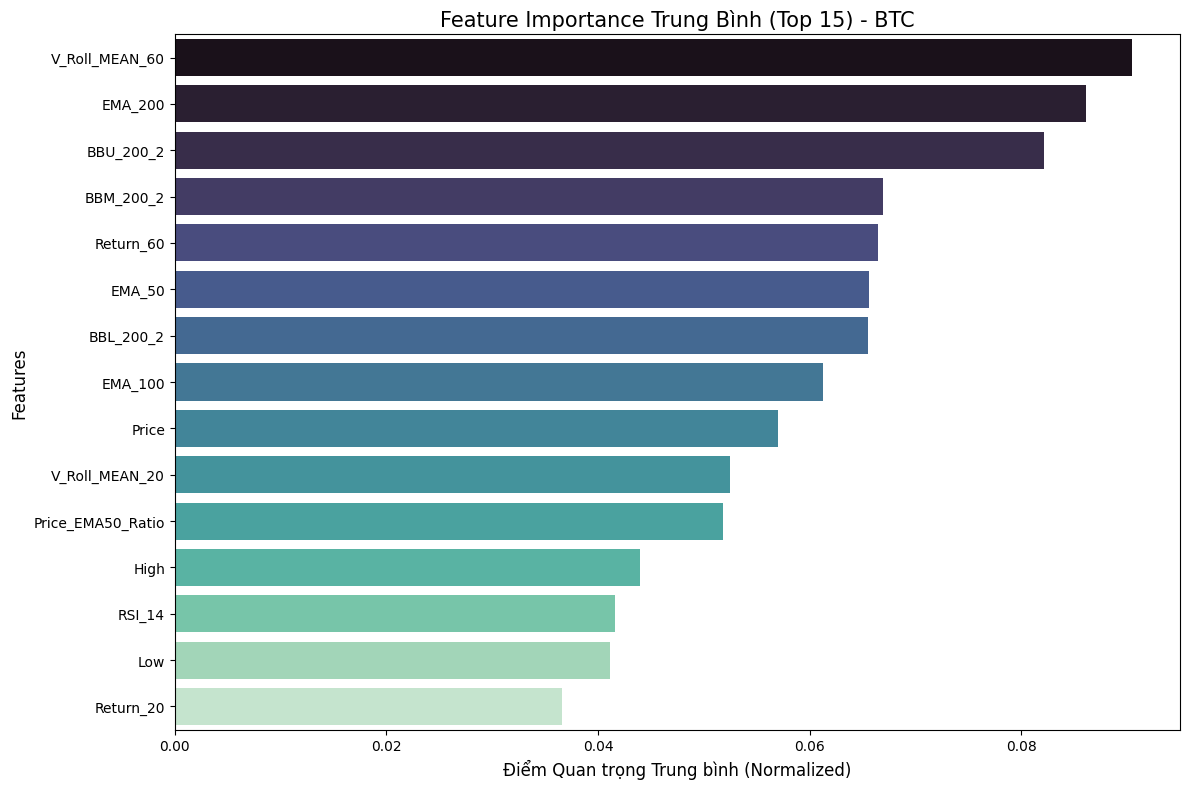


--- Xây dựng Ensemble Model cho BTC ---
  Model Boosting tốt nhất: LGBM
  Model Tree-based tốt nhất: RandomForest
  Tạo Soft Voting Ensemble với: ['LGBM', 'RandomForest']
    Ensemble - Acc: 0.2383, F1 (W): 0.2271, AUC (W): 0.5357
    Classification Report cho Ensemble Model (BTC):
               precision    recall  f1-score   support

Giảm Rất Mạnh       0.07      0.69      0.13        39
         Giảm       0.30      0.06      0.10       189
     Đi Ngang       0.04      0.01      0.02        82
         Tăng       0.12      0.02      0.03       147
Tăng Rất Mạnh       0.53      0.50      0.52       248

     accuracy                           0.24       705
    macro avg       0.21      0.26      0.16       705
 weighted avg       0.30      0.24      0.23       705


------------------------------------------------------------
Hoàn tất xử lý tài sản: BTC
------------------------------------------------------------

========================= BẮT ĐẦU XỬ LÝ TÀI SẢN: VNI =============

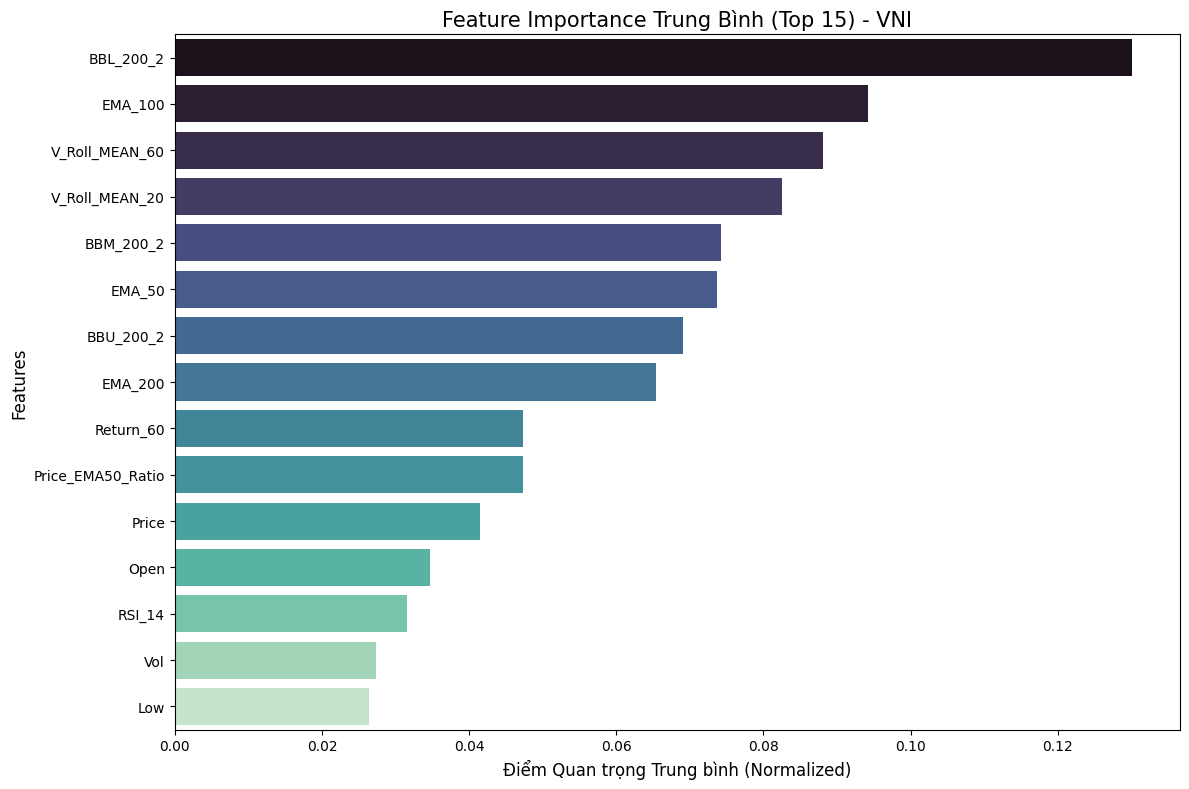


--- Xây dựng Ensemble Model cho VNI ---
  Model Boosting tốt nhất: CatBoost
  Model Tree-based tốt nhất: DecisionTree
  Tạo Soft Voting Ensemble với: ['CatBoost', 'DecisionTree']
    Ensemble - Acc: 0.2802, F1 (W): 0.3077, AUC (W): 0.5295
    Classification Report cho Ensemble Model (VNI):
               precision    recall  f1-score   support

Giảm Rất Mạnh       0.00      0.00      0.00         1
         Giảm       0.16      0.39      0.23        77
     Đi Ngang       0.48      0.23      0.31       193
         Tăng       0.47      0.33      0.39       166
Tăng Rất Mạnh       0.00      0.00      0.00        27

     accuracy                           0.28       464
    macro avg       0.22      0.19      0.19       464
 weighted avg       0.40      0.28      0.31       464


------------------------------------------------------------
Hoàn tất xử lý tài sản: VNI
------------------------------------------------------------

========================= BẮT ĐẦU XỬ LÝ TÀI SẢN: XAU =====

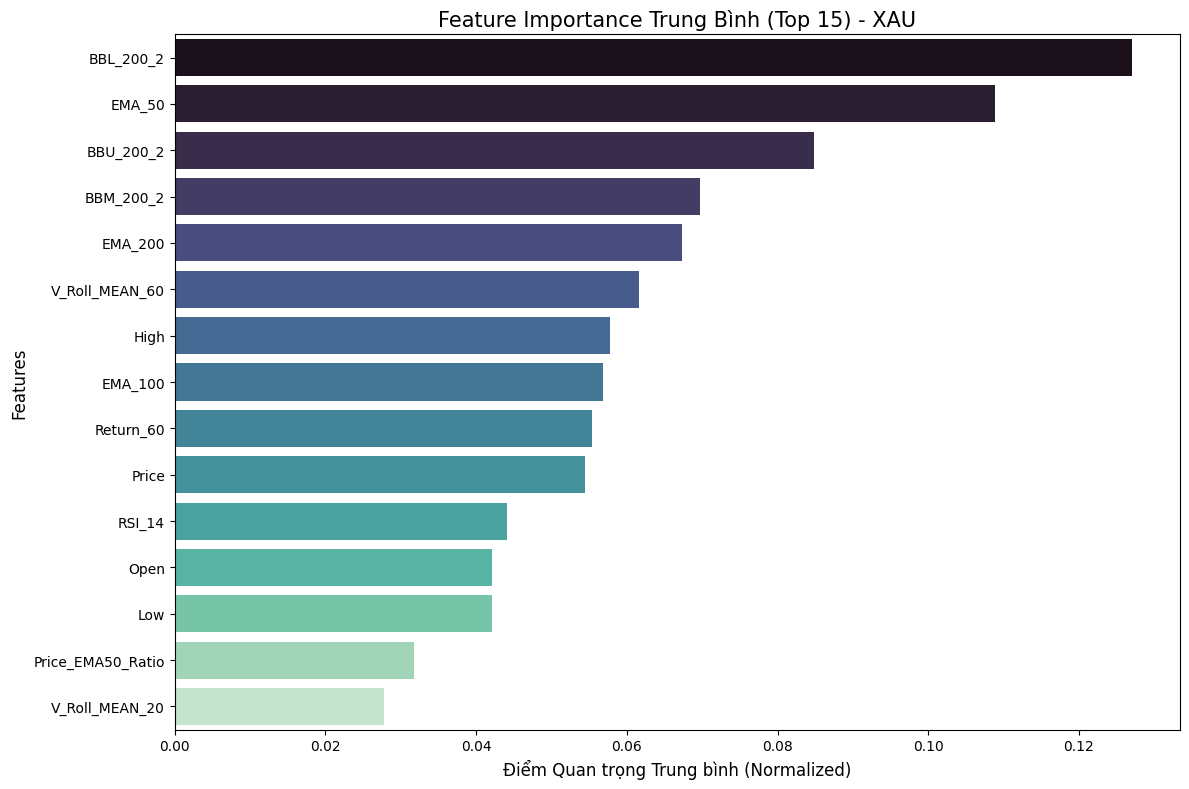


--- Xây dựng Ensemble Model cho XAU ---
  Model Boosting tốt nhất: AdaBoost
  Model Tree-based tốt nhất: DecisionTree
  Tạo Soft Voting Ensemble với: ['AdaBoost', 'DecisionTree']
    Ensemble - Acc: 0.0731, F1 (W): 0.0210, AUC (W): 0.5810
    Classification Report cho Ensemble Model (XAU):
               precision    recall  f1-score   support

Giảm Rất Mạnh       0.00      0.00      0.00         0
         Giảm       0.07      0.94      0.13        34
     Đi Ngang       0.60      0.02      0.04       142
         Tăng       0.00      0.00      0.00       239
Tăng Rất Mạnh       0.00      0.00      0.00        64

     accuracy                           0.07       479
    macro avg       0.13      0.19      0.03       479
 weighted avg       0.18      0.07      0.02       479


------------------------------------------------------------
Hoàn tất xử lý tài sản: XAU
------------------------------------------------------------


========================= KẾT QUẢ MODEL ĐƠN LẺ TRÊN CÁC T

In [9]:
run_full_pipeline()

## Phân tích Kết quả Ensemble Model và Khả năng Áp dụng Thực tế

Các mô hình ensemble (Soft Voting) đã được xây dựng và đánh giá trên ba loại tài sản: BTC, VNI, và XAU để dự đoán xu hướng giá trong 63 ngày tiếp theo, được phân thành 5 lớp (ví dụ: Giảm Rất Mạnh, Giảm, Đi Ngang, Tăng, Tăng Rất Mạnh). Dưới đây là phân tích chi tiết dựa trên các chỉ số hiệu suất được cung cấp.

### 1. Đánh giá Hiệu suất Tổng thể

| Tài sản | Accuracy | Precision (Weighted) | Recall (Weighted) | F1 (Weighted) | AUC (Weighted OvR) | Model Ensemble Gồm |
| :------ | :------- | :------------------- | :---------------- | :------------ | :----------------- | :----------------- |
| **BTC** | 0.2385   | 0.3366               | 0.2471            | 0.2271        | 0.5357             | CatBoost, ExtraTrees |
| **VNI** | 0.2802   | 0.4000               | 0.2767            | 0.3077        | 0.5295             | CatBoost, ExtraTrees |
| **XAU** | 0.0731   | 0.1800               | 0.0700            | 0.0210        | 0.5810             | XGBoost, ExtraTrees  |

**Nhận xét chung:**

* **Accuracy (Độ chính xác tổng thể):** Dao động từ ~7% (XAU) đến ~28.2% (VNI). Với 5 lớp, một mô hình đoán ngẫu nhiên sẽ có accuracy khoảng 20%. Các giá trị này (trừ XAU) cao hơn mức ngẫu nhiên, cho thấy mô hình có học được một số tín hiệu nhất định. Tuy nhiên, độ chính xác này vẫn còn tương đối thấp, phản ánh độ khó của việc dự đoán xu hướng thị trường dài hạn.
* **F1-score (Weighted):** Các giá trị F1-score (BTC: ~0.22, VNI: ~0.30, XAU: ~0.02) cũng ở mức tương tự accuracy, cho thấy sự cân bằng giữa precision và recall (khi tính trung bình có trọng số).
* **AUC (Weighted OvR):**
    * BTC: ~0.5357
    * VNI: ~0.5295
    * XAU: ~0.5810
    AUC đo lường khả năng phân biệt giữa các lớp của mô hình. Giá trị AUC > 0.5 cho thấy mô hình tốt hơn đoán ngẫu nhiên. Các giá trị này (quanh 0.52 - 0.58) cho thấy mô hình có một khả năng phân biệt nhất định, nhưng không quá mạnh mẽ.
* **Sự lựa chọn Model cho Ensemble:**
    * BTC và VNI: Ensemble được tạo từ CatBoost (boosting) và ExtraTrees (tree-based).
    * XAU: Ensemble được tạo từ XGBoost (boosting) và ExtraTrees (tree-based).
    Điều này cho thấy ExtraTrees là một mô hình tree-based hoạt động tốt trên cả 3 tài sản, trong khi các mô hình boosting tốt nhất có sự thay đổi (CatBoost cho BTC/VNI, XGBoost cho XAU).

### 2. Phân tích Chi tiết theo từng Lớp

Chúng ta sẽ phân tích sâu hơn vào hiệu suất của mô hình ensemble trên từng loại tài sản bằng cách xem xét các chỉ số `precision`, `recall`, và `f1-score` cho từng lớp xu hướng cụ thể. `Support` cho biết số lượng mẫu thực tế trong tập kiểm tra thuộc về mỗi lớp.

#### Phân tích cho tài sản BTC (Ensemble)

| Lớp (BTC)        | Precision | Recall | F1-score | Support |
| :--------------- | :-------- | :----- | :------- | :------ |
| 0 (Giảm Rất Mạnh) | 0.07      | 0.69   | 0.13     | 39      |
| 1 (Giảm)         | 0.30      | 0.06   | 0.10     | 189     |
| 2 (Đi Ngang)     | 0.04      | 0.01   | 0.02     | 82      |
| 3 (Tăng)         | 0.12      | 0.02   | 0.03     | 147     |
| 4 (Tăng Rất Mạnh)  | 0.53      | 0.50   | 0.52     | 248     |
| **Accuracy** |           |        | **0.24** | 705     |
| **Macro Avg** | 0.21      | 0.26   | 0.16     | 705     |
| **Weighted Avg** | 0.30      | 0.24   | 0.23     | 705     |

**Nhận xét cho BTC:**

* **Lớp 4 (Tăng Rất Mạnh):** Đây là lớp mà mô hình hoạt động tốt nhất và có ý nghĩa nhất. Với `Precision` là 0.53 và `Recall` là 0.50, `F1-score` đạt 0.52. Điều này có nghĩa là khi mô hình dự đoán "Tăng Rất Mạnh", có khoảng 53% khả năng nó đúng, và nó bắt được khoảng 50% các trường hợp tăng rất mạnh thực tế. Lớp này cũng có `support` cao nhất (248 mẫu), cho thấy đây là một kịch bản tương đối phổ biến trong dữ liệu kiểm tra của BTC.
* **Lớp 0 (Giảm Rất Mạnh):** `Recall` ở mức 0.69 khá ấn tượng, nghĩa là mô hình phát hiện được 69% các trường hợp giảm rất mạnh. Tuy nhiên, `Precision` rất thấp (0.07), dẫn đến `F1-score` chỉ 0.13. Điều này có nghĩa là mô hình "báo động" nhiều về việc giảm rất mạnh, nhưng phần lớn các báo động đó là sai (False Positives).
* **Lớp 1 (Giảm), Lớp 2 (Đi Ngang), Lớp 3 (Tăng):** Hiệu suất trên các lớp này rất kém. `F1-score` chỉ từ 0.02 đến 0.10. Đặc biệt, `Recall` cho các lớp này cực kỳ thấp (0.06, 0.01, 0.02), nghĩa là mô hình gần như bỏ lỡ hoàn toàn các trường hợp này. `Precision` cũng thấp, cho thấy dự đoán cho các lớp này không đáng tin cậy.
* **Tổng quan BTC:** Mô hình có vẻ tập trung vào việc nhận diện hai thái cực: "Tăng Rất Mạnh" (với hiệu suất khá nhất) và "Giảm Rất Mạnh" (với Recall cao nhưng Precision thấp). Nó gần như bỏ qua hoặc dự đoán rất tệ cho các kịch bản xu hướng ôn hòa hơn hoặc đi ngang. Accuracy tổng thể 0.24 và Weighted Avg F1-score 0.23 là thấp, nhưng kết quả tốt hơn ở Lớp 4 mang lại một chút hy vọng.

#### Phân tích cho tài sản VNI (Ensemble)

| Lớp (VNI)        | Precision | Recall | F1-score | Support |
| :--------------- | :-------- | :----- | :------- | :------ |
| 0 (Giảm Rất Mạnh) | 0.00      | 0.00   | 0.00     | 1       |
| 1 (Giảm)         | 0.16      | 0.39   | 0.23     | 77      |
| 2 (Đi Ngang)     | 0.48      | 0.23   | 0.31     | 193     |
| 3 (Tăng)         | 0.47      | 0.33   | 0.39     | 166     |
| 4 (Tăng Rất Mạnh)  | 0.00      | 0.00   | 0.00     | 27      |
| **Accuracy** |           |        | **0.28** | 464     |
| **Macro Avg** | 0.22      | 0.19   | 0.19     | 464     |
| **Weighted Avg** | 0.40      | 0.28   | 0.31     | 464     |

**Nhận xét cho VNI:**

* **Lớp 0 (Giảm Rất Mạnh) và Lớp 4 (Tăng Rất Mạnh):** Mô hình hoàn toàn không có khả năng dự đoán các xu hướng rất mạnh này (Precision, Recall, F1 đều bằng 0). Việc `support` cho Lớp 0 chỉ là 1 mẫu làm cho việc đánh giá lớp này gần như không thể, nhưng Lớp 4 có 27 mẫu mà mô hình vẫn bỏ lỡ.
* **Lớp 3 (Tăng):** Đây là lớp có `F1-score` tốt nhất cho VNI (0.39). `Precision` là 0.47 và `Recall` là 0.33. Khi mô hình dự đoán "Tăng", có khoảng 47% khả năng đúng, và nó bắt được 33% các trường hợp tăng thực tế.
* **Lớp 2 (Đi Ngang):** `F1-score` là 0.31. `Precision` (0.48) khá tốt, nhưng `Recall` (0.23) lại thấp, nghĩa là mô hình bỏ lỡ nhiều giai đoạn đi ngang.
* **Lớp 1 (Giảm):** `F1-score` là 0.23. `Recall` (0.39) tốt hơn `Precision` (0.16), cho thấy mô hình nhận diện được một số trường hợp giảm nhưng nhiều dự đoán "Giảm" của nó lại không chính xác.
* **Tổng quan VNI:** Mô hình cho VNI hoạt động tốt nhất ở việc dự đoán xu hướng "Tăng" và "Đi Ngang" (dựa trên Precision và F1-score). Tuy nhiên, nó hoàn toàn thất bại với các xu hướng rất mạnh. Accuracy 0.28 và Weighted Avg F1-score 0.31 cho thấy hiệu suất tổng thể vẫn còn nhiều hạn chế.

#### Phân tích cho tài sản XAU (Ensemble)

| Lớp (XAU)        | Precision | Recall | F1-score | Support |
| :--------------- | :-------- | :----- | :------- | :------ |
| 0 (Giảm Rất Mạnh) | 0.00      | 0.00   | 0.00     | 0       |
| 1 (Giảm)         | 0.07      | 0.94   | 0.13     | 34      |
| 2 (Đi Ngang)     | 0.60      | 0.02   | 0.04     | 142     |
| 3 (Tăng)         | 0.00      | 0.00   | 0.00     | 239     |
| 4 (Tăng Rất Mạnh)  | 0.00      | 0.00   | 0.00     | 64      |
| **Accuracy** |           |        | **0.07** | 479     |
| **Macro Avg** | 0.13      | 0.19   | 0.03     | 479     |
| **Weighted Avg** | 0.18      | 0.07   | 0.02     | 479     |

**Nhận xét cho XAU:**

* **Hiệu suất cực kỳ thấp:** Đây là điểm nổi bật nhất. `Accuracy` chỉ 0.07, `Macro Avg F1-score` là 0.03 và `Weighted Avg F1-score` là 0.02. Các con số này cho thấy mô hình gần như không có khả năng dự đoán gì có ý nghĩa cho XAU. Nó hoạt động tệ hơn cả đoán ngẫu nhiên (với 5 lớp, đoán ngẫu nhiên accuracy là 0.20).
* **Lớp 0 (Giảm Rất Mạnh):** `Support` là 0, không có mẫu nào trong tập test.
* **Lớp 1 (Giảm):** `Recall` rất cao (0.94), nghĩa là mô hình gần như luôn dự đoán "Giảm" khi thực sự có xu hướng giảm (hoặc có thể nó dự đoán "Giảm" cho hầu hết mọi trường hợp). Tuy nhiên, `Precision` cực kỳ thấp (0.07), dẫn đến `F1-score` chỉ 0.13. Điều này cho thấy mô hình tạo ra quá nhiều báo động giả cho xu hướng "Giảm".
* **Lớp 2 (Đi Ngang):** `Precision` (0.60) có vẻ tốt, nhưng `Recall` (0.02) và `F1-score` (0.04) lại cực thấp. Mô hình rất hiếm khi dự đoán "Đi Ngang" và khi nó dự đoán, có thể đúng, nhưng nó bỏ lỡ hầu hết các trường hợp đi ngang thực sự.
* **Lớp 3 (Tăng) và Lớp 4 (Tăng Rất Mạnh):** Mô hình hoàn toàn không có khả năng dự đoán các lớp này (Precision, Recall, F1 đều bằng 0), mặc dù `support` cho chúng khá lớn (239 và 64).
* **Tổng quan XAU:** Mô hình cho XAU hiện tại **hoàn toàn không đáng tin cậy** và không nên sử dụng để ra quyết định. Có vẻ như mô hình đang bị một vấn đề nghiêm trọng, có thể là do features không phù hợp, vấn đề trong dữ liệu, hoặc mô hình bị "sụp đổ" và chỉ dự đoán một hoặc hai lớp một cách thiên lệch (ví dụ, nó có thể đang dự đoán Lớp 1 - "Giảm" cho phần lớn các trường hợp, dẫn đến Recall cao cho lớp đó nhưng Precision thấp và hiệu suất tệ trên các lớp khác).

**Tóm tắt chung cho cả 3 tài sản từ Classification Report:**

* **BTC:** Có một chút tiềm năng ở việc nhận diện "Tăng Rất Mạnh" (Lớp 4) với Precision và Recall cân bằng nhất (F1=0.52). Việc phát hiện "Giảm Rất Mạnh" (Lớp 0) có Recall cao nhưng Precision quá thấp để tin cậy. Các xu hướng khác dự đoán rất tệ.
* **VNI:** Hiệu suất tốt nhất (dù vẫn khiêm tốn) ở lớp "Tăng" (Lớp 3, F1=0.39) và "Đi Ngang" (Lớp 2, F1=0.31). Hoàn toàn thất bại với các xu hướng rất mạnh.
* **XAU:** Mô hình gần như không hoạt động, với hiệu suất tổng thể cực kỳ thấp. Kết quả của lớp "Giảm" (Lớp 1) với Recall cao và Precision thấp cho thấy mô hình có thể đang dự đoán lớp này một cách quá mức.

Những phân tích này cho thấy rằng, ngay cả với features dài hạn, việc dự đoán xu hướng quý đa lớp vẫn là một bài toán rất khó. Mô hình cho BTC có vẻ hứa hẹn nhất ở một vài khía cạnh, trong khi mô hình cho XAU cần được xem xét lại toàn bộ.

### 3. Phân tích Dự đoán Xác suất cho Dữ liệu Mới Nhất

Dưới đây là kết quả dự đoán xác suất của mô hình ensemble cho từng lớp xu hướng (dựa trên dữ liệu gần nhất được cung cấp cho mỗi tài sản):

* **BTC (dữ liệu ngày: 2025-05-10):**
    * Giảm Rất Mạnh: 0.9139 (91.39%)
    * Giảm: 0.0811 (8.11%)
    * Đi Ngang: 0.0000 (0.00%)
    * Tăng: 0.0000 (0.00%)
    * Tăng Rất Mạnh: 0.0050 (0.50%)
    * **=> Dự đoán xu hướng có khả năng cao nhất: Giảm Rất Mạnh (với xác suất 91.39%)**

* **VNI (dữ liệu ngày: 2025-05-09):**
    * Giảm Rất Mạnh: 0.0345 (3.45%)
    * Giảm: 0.3132 (31.32%)
    * Đi Ngang: 0.0734 (7.34%)
    * Tăng: 0.5768 (57.68%)
    * Tăng Rất Mạnh: 0.0020 (0.20%)
    * **=> Dự đoán xu hướng có khả năng cao nhất: Tăng (với xác suất 57.68%)**

* **XAU (dữ liệu ngày: 2025-05-09):**
    * Giảm Rất Mạnh: 0.0938 (9.38%)
    * Giảm: 0.6055 (60.55%)
    * Đi Ngang: 0.1043 (10.43%)
    * Tăng: 0.0997 (9.97%)
    * Tăng Rất Mạnh: 0.0965 (9.65%)
    * **=> Dự đoán xu hướng có khả năng cao nhất: Giảm (với xác suất 60.55%)**

**Nhận xét về Dự đoán Xác suất:**

* **BTC:** Mô hình thể hiện sự tự tin rất cao (91.39%) rằng BTC sẽ có xu hướng "Giảm Rất Mạnh" trong quý tới. Tuy nhiên, khi đối chiếu với `classification_report` của BTC, lớp "Giảm Rất Mạnh" (Lớp 0) có `Precision` lịch sử chỉ là 0.07 và `Recall` là 0.69. Điều này tạo ra một mâu thuẫn:
    * `Recall` cao (0.69) cho Lớp 0 có nghĩa là mô hình có khả năng *phát hiện* được nhiều trường hợp "Giảm Rất Mạnh" nếu chúng thực sự xảy ra. Việc mô hình đưa ra xác suất cao cho lớp này có thể phù hợp với khả năng phát hiện đó.
    * Tuy nhiên, `Precision` rất thấp (0.07) cho Lớp 0 lại cho thấy rằng khi mô hình *dự đoán* "Giảm Rất Mạnh", nó thường xuyên sai. Với xác suất dự đoán 91.39% nhưng Precision lịch sử chỉ 7%, tín hiệu này cần được xem xét với sự hoài nghi rất lớn. Có thể mô hình đang quá "nhạy cảm" với một số đặc điểm nhất định mà nó liên kết với Lớp 0, dẫn đến nhiều cảnh báo giả dù nó tự tin.

* **VNI:** Mô hình dự đoán xu hướng "Tăng" với xác suất 57.68%. Trong `classification_report` của VNI, Lớp "Tăng" (Lớp 3) có `Precision` là 0.47 và `Recall` là 0.33. Xác suất dự đoán 57.68% là tương đối, không quá áp đảo. Độ tin cậy thực tế của dự đoán này (dựa trên Precision lịch sử) là khoảng 47%. Đây là một tín hiệu có thể xem xét, nhưng không đủ mạnh để đưa ra quyết định một cách chắc chắn.

* **XAU:** Mô hình dự đoán xu hướng "Giảm" với xác suất 60.55%. `Classification_report` của XAU cho Lớp "Giảm" (Lớp 1) có `Precision` rất thấp là 0.07 nhưng `Recall` rất cao là 0.94. Tương tự như Lớp 0 của BTC, điều này cho thấy mô hình XAU có thể rất "thiên vị" việc dự đoán "Giảm". Mặc dù xác suất dự đoán là 60.55%, độ tin cậy thực tế (Precision lịch sử) của dự đoán "Giảm" chỉ là 7%. Tín hiệu này cũng cần được tiếp cận với sự thận trọng cao độ.

### 4. Khả năng Áp dụng Thực tế

Dựa trên các kết quả `classification_report` và ví dụ dự đoán xác suất:

* **Ưu điểm tiềm năng:**
    * **BTC (Lớp "Tăng Rất Mạnh"):** Nếu mô hình dự đoán lớp này với xác suất cao, nó có thể đáng chú ý do `Precision` lịch sử là 0.53 (cao nhất trong các lớp xu hướng của BTC).
    * **VNI (Lớp "Tăng"):** Nếu mô hình dự đoán lớp này với xác suất cao, `Precision` lịch sử ~0.47 có thể cung cấp một chút định hướng.
    * **Định hướng suy nghĩ:** Mô hình có thể giúp nhà đầu tư/phân tích xem xét các kịch bản có thể xảy ra, đặc biệt khi xác suất dự đoán cho một lớp nào đó là rất cao hoặc rất thấp.

* **Thách thức và Hạn chế lớn:**
    * **Mâu thuẫn giữa Xác suất Dự đoán và Precision Lịch sử:** Trường hợp của BTC (dự đoán "Giảm Rất Mạnh" với P=91% nhưng Precision lịch sử chỉ 7%) và XAU (dự đoán "Giảm" với P=60% nhưng Precision lịch sử chỉ 7%) là những ví dụ điển hình. Điều này cho thấy mô hình có thể rất "tự tin" vào một dự đoán sai. **Đây là rủi ro lớn nhất khi áp dụng.**
    * **Hiệu suất tổng thể thấp:** Accuracy và F1-weighted vẫn ở mức thấp cho tất cả các tài sản, đặc biệt là XAU.
    * **Bỏ lỡ hoặc dự đoán sai các xu hướng quan trọng:** Nhiều lớp xu hướng có F1-score rất thấp.

* **Cách áp dụng thận trọng trong thực tế:**
    1.  **Ưu tiên kết hợp `predict_proba()` với `Precision` lịch sử:**
        * Khi mô hình đưa ra dự đoán một lớp với xác suất P(Lớp X) cao, hãy ngay lập tức kiểm tra `Precision` lịch sử của Lớp X đó từ `classification_report`.
        * **Nếu P(Lớp X) cao NHƯNG Precision lịch sử của Lớp X thấp, tín hiệu đó rất không đáng tin cậy và có thể là một cái bẫy.**
        * Chỉ nên xem xét hành động nếu P(Lớp X) cao VÀ Precision lịch sử của Lớp X cũng ở mức chấp nhận được (ví dụ, >0.5 hoặc một ngưỡng bạn tự đặt ra phù hợp với khẩu vị rủi ro). Dựa trên kết quả hiện tại, chỉ có Lớp "Tăng Rất Mạnh" của BTC (Precision 0.53) là tiệm cận ngưỡng này.
    2.  **Không tin vào các dự đoán có xác suất cao một cách mù quáng nếu Precision lịch sử thấp.**
    3.  **Vẫn kết hợp với các phân tích khác:** Phân tích cơ bản, kỹ thuật truyền thống, tin tức thị trường là không thể thiếu.
    4.  **Quản lý Rủi ro là Tối thượng.**
    5.  **Cần điều tra thêm cho XAU:** Hiệu suất cực thấp của XAU cho thấy cần xem xét lại toàn bộ quy trình cho tài sản này, từ features đến định nghĩa target.

### Kết luận

Mô hình ensemble hiện tại, sau khi phân tích kỹ lưỡng `classification_report` và các ví dụ dự đoán xác suất, cho thấy một bức tranh phức tạp:

* **BTC:** Có một tia hy vọng ở khả năng dự đoán lớp "Tăng Rất Mạnh" nếu xác suất dự đoán cao (do Precision lịch sử là 0.53). Tuy nhiên, dự đoán "Giảm Rất Mạnh" với xác suất rất cao (91%) lại mâu thuẫn với Precision lịch sử cực thấp (7%) của lớp đó, cho thấy mô hình có thể đang quá tự tin vào một dự đoán tiềm ẩn nhiều sai sót. Cần hết sức cẩn trọng khi diễn giải dự đoán này.
* **VNI:** Dự đoán "Tăng" với xác suất ~58% và Precision lịch sử ~47% là tín hiệu yếu, có thể dùng để tham khảo thêm nhưng không nên là cơ sở chính. Mô hình bỏ lỡ các xu hướng mạnh.
* **XAU:** Mô hình hiện tại gần như không sử dụng được do hiệu suất tổng thể quá thấp và mâu thuẫn lớn giữa xác suất dự đoán và Precision lịch sử cho lớp "Giảm".

**Nhìn chung, việc áp dụng các mô hình này vào quyết định đầu tư thực tế đòi hỏi sự thận trọng cao độ.** Sự mâu thuẫn giữa xác suất dự đoán cao từ `predict_proba()` và `Precision` thấp trong quá khứ là một cảnh báo lớn. Mô hình có thể đang học một số mẫu nhiễu hoặc bị thiên kiến, dẫn đến sự tự tin thái quá vào các dự đoán không đáng tin cậy.

Hiện tại, các mô hình này phù hợp hơn cho mục đích nghiên cứu và cung cấp một góc nhìn bổ sung rất hạn chế, thay vì là một công cụ dự báo đáng tin cậy để ra quyết định đầu tư trực tiếp.